# Using a dataset of recommendations, build machine-learning models that recommend articles to a new user. Specifically, build online learning models and supervised learning models, and compare the results. First, build three multi-armed bandits using Epsilon greedy, UCB1, and Thompson Sampling algorithms. You may use only two features from the dataset: ‘Recommendation’ and ‘Reward’. Second, build contextual bandits using the reward and historical data provided. Third, build three classification models using the features ‘Age’ and ‘Gender’ to predict recommendations for the new user.

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
from sklearn.metrics import accuracy_score

In [99]:
data = pd.read_csv('SimulatedArticleData.csv', index_col=[0])
data.head()

,Gender,Age,Recommendation,Reward
0,m,29.0,health,0
1,m,28.0,movies,1
2,m,34.0,news,1
3,m,36.0,health,0
4,f,24.0,news,0


In [100]:
msk = np.random.rand(len(data)) < 0.8
dataset = data[msk]
test = data[~msk]
dataset.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [101]:
dataset.head()

,Gender,Age,Recommendation,Reward
0,m,29.0,health,0
1,m,28.0,movies,1
2,m,34.0,news,1
3,m,36.0,health,0
4,f,61.0,sports,0


# multi-armed bandits 

In [102]:
DF = dataset[['Recommendation','Reward']]
N = len(DF) # number of trail
DF.head()

,Recommendation,Reward
0,health,0
1,movies,1
2,news,1
3,health,0
4,sports,0


In [103]:
Arms = dataset['Recommendation'].unique().tolist()
dec = {Arms[0]:1,
       Arms[1]:1,
       Arms[2]:1,
       Arms[3]:1,
}

In [104]:
Arms

['health', 'movies', 'news', 'sports']

In [105]:
dec

{'health': 1, 'movies': 1, 'news': 1, 'sports': 1}

# Epsilon greedy

In [106]:
ads_selected = []
numbers_of_selections = dec.copy()
sums_of_rewards = dec.copy()
total_reward = 0

eps = 0.8 # change it between 0 and 1
for n in range(0, N):

    if np.random.random() < eps:
        # you can use np.random.choice with number of Arms to generate random number between 0 and 1
        ad = np.random.choice(Arms) # your code is here
    else:
        ad = max(sums_of_rewards, key=sums_of_rewards.get)
    
    ads_selected.append(ad)
    
    numbers_of_selections[ad] = numbers_of_selections[ad] + 1
    reward = DF.Reward[n]
    sums_of_rewards[ad] = sums_of_rewards[ad] + reward
    total_reward = total_reward + reward

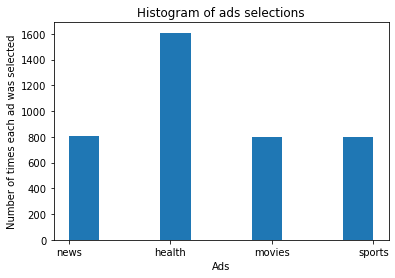

In [107]:
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

In [108]:
pd.Series(ads_selected).value_counts()

health    1608
news       808
movies     802
sports     795
dtype: int64

In [109]:
testEG = test.copy()
testEG['prediction'] = pd.Series(ads_selected).value_counts().idxmax()
testEG["Recommendation"] = testEG["Recommendation"].astype('category')
testEG["prediction"] = testEG["prediction"].astype('category')
testEG["prediction"] = testEG["prediction"].cat.codes
testEG["Recommendation"] = testEG["Recommendation"].cat.codes
accuracy_score(testEG["Recommendation"] , testEG["prediction"])

0.25329280648429586

# UCB1

In [110]:
import math
ads_selected = []
numbers_of_selections = dec.copy()
sums_of_rewards = dec.copy()
Total_upper_bound = dec.copy()
total_reward = 0
for n in range(200):
    # you can use np.random.choice with number of Arms to generate random number between 0 and 1; we assume the user click here
    ad = np.random.choice(Arms) # your code is here
    ads_selected.append(ad)   
    numbers_of_selections[ad] = numbers_of_selections[ad] + 1
    reward = DF.Reward[n]
    sums_of_rewards[ad] = sums_of_rewards[ad] + reward
    total_reward = total_reward + reward
    
    
for n in range(200, N):
    average_reward = sums_of_rewards[ad] / numbers_of_selections[ad]
    # you can use math.sqrt, math.log(n + 1) and  numbers_of_selections[ad])
    delta_i = math.sqrt((math.log(n + 1))/numbers_of_selections[ad]) # your code is here
    upper_bound = average_reward + delta_i
    Total_upper_bound[ad] = Total_upper_bound[ad] + upper_bound

    ad = max(Total_upper_bound, key=Total_upper_bound.get)   
    ads_selected.append(ad)
    
    numbers_of_selections[ad] = numbers_of_selections[ad] + 1
    reward = DF.Reward[n]
    sums_of_rewards[ad] = sums_of_rewards[ad] + reward
    total_reward = total_reward + reward

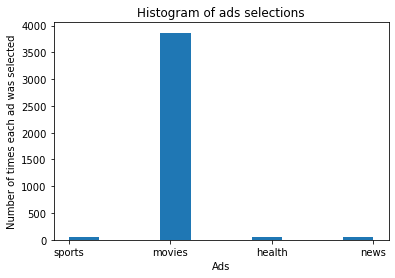

In [111]:
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

In [112]:
pd.Series(ads_selected).value_counts()

movies    3866
sports      51
health      50
news        46
dtype: int64

In [113]:
testUCB = test.copy()
testUCB['prediction'] = pd.Series(ads_selected).value_counts().idxmax()
testUCB["Recommendation"] = testUCB["Recommendation"].astype('category')
testUCB["prediction"] = testUCB["prediction"].astype('category')
testUCB["prediction"] = testUCB["prediction"].cat.codes
testUCB["Recommendation"] = testUCB["Recommendation"].cat.codes
accuracy_score(testUCB["Recommendation"] , testUCB["prediction"])

0.25329280648429586

# Thompson Sampling

In [114]:
import random
ads_selected = []
numbers_of_rewards_S = dec.copy()
numbers_of_rewards_F = dec.copy()
BetaArms = dec.copy()

total_reward = 0

ad = 'news'

for n in range(0, N):
    for key in dec:
        # use beta distribution may you wanr to use random.betavariate with numbers_of_rewards_S[key] + 1 and numbers_of_rewards_F[key] + 1
        BetaArms[key] = (np.random.beta(numbers_of_rewards_S[key] + 1, numbers_of_rewards_F[key] + 1))# your code is here
    ad = max(BetaArms, key=BetaArms.get) 
        
    ads_selected.append(ad)
    
    
    reward = DF.Reward[n]
    if reward == 1:
        numbers_of_rewards_S[ad] = numbers_of_rewards_S[ad] + 1
    else:
        numbers_of_rewards_F[ad] = numbers_of_rewards_F[ad] + 1
    total_reward = total_reward + reward

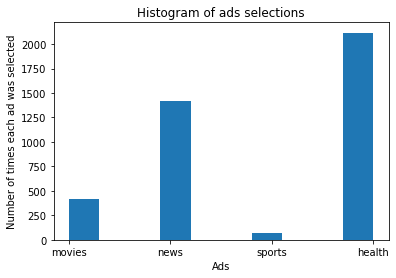

In [115]:
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

In [116]:
pd.Series(ads_selected).value_counts()

health    2116
news      1414
movies     416
sports      67
dtype: int64

In [117]:
testTS = test.copy()
testTS['prediction'] = pd.Series(ads_selected).value_counts().idxmax()
testTS["Recommendation"] = testTS["Recommendation"].astype('category')
testTS["prediction"] = testTS["prediction"].astype('category')
testTS["prediction"] = testTS["prediction"].cat.codes
testTS["Recommendation"] = testTS["Recommendation"].cat.codes
accuracy_score(testTS["Recommendation"] , testTS["prediction"])

0.25329280648429586

# Contextual bandit

In [118]:
len(Arms)

4

In [119]:
dfContBand = dataset.copy()

In [120]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(dfContBand['Recommendation'])
dfContBand['Recommendation'] = le.transform(dfContBand['Recommendation'])
le.classes_

array(['health', 'movies', 'news', 'sports'], dtype=object)

In [121]:
le.inverse_transform([0, 1, 2, 3])

array(['health', 'movies', 'news', 'sports'], dtype=object)

In [122]:
dfContBand['probability'] = 0.5
dfContBand['cost'] = 0 - dfContBand['Reward']
dfContBand.head()

,Gender,Age,Recommendation,Reward,probability,cost
0,m,29.0,0,0,0.5,0
1,m,28.0,1,1,0.5,-1
2,m,34.0,2,1,0.5,-1
3,m,36.0,0,0,0.5,0
4,f,61.0,3,0,0.5,0


# Build the Model

In [123]:
!pip3 install vowpalwabbit

In [124]:
from vowpalwabbit import pyvw
#  --cb 4  ==> Number of action
vw = pyvw.vw("--cb 4 ") #your code is here

C:\Users\Bharani\AppData\Local\Temp\ipykernel_20820\1038598857.py:3: DeprecationWarning: vw has been renamed to Workspace, the alias will be removed in the future
  vw = pyvw.vw("--cb 4 ") #your code is here


In [125]:
# Define the parameters

for i in dfContBand.index:
  action = dfContBand.loc[i, "Recommendation"]
  cost = dfContBand.loc[i, "cost"]
  probability = dfContBand.loc[i, "probability"]
  Gender = dfContBand.loc[i, "Gender"]
  Age = dfContBand.loc[i, "Age"]

  # Construct the example in the required vw format.
  learn_example = str(action) + ":" + str(cost) + ":" + str(probability) +  " | " + str(Gender) + " " + str(Age)

  # Here we do the actual learning.
  # your code is here

In [126]:
print("Show action number ", le.inverse_transform([vw.predict('|m 29')]))

Show action number  ['movies']


In [127]:
le.inverse_transform([3])

array(['sports'], dtype=object)

In [128]:
dstwst = dataset[['Gender','Age']]

In [129]:
target = []
dstwst=test.copy()
for j in dstwst.index:
    Gender = dstwst.loc[j, "Gender"]
    Age = dstwst.loc[j, "Age"]
    test_example = "| " + str(Gender) + " " + str(Age)
    choice = vw.predict(test_example)
    target.append(choice)
dstwst['prediction'] = le.inverse_transform(target)

In [130]:
dstwst.head()

,Gender,Age,Recommendation,Reward,prediction
0,f,24.0,news,0,movies
1,m,85.0,news,0,movies
2,f,19.0,news,0,movies
3,m,87.0,health,1,movies
4,m,28.0,sports,1,movies


In [131]:
dstwst["Recommendation"] = dstwst["Recommendation"].astype('category')
dstwst["Recommendation"] = dstwst["Recommendation"].cat.codes
dstwst["prediction"] = dstwst["prediction"].astype('category')
dstwst["prediction"] = dstwst["prediction"].cat.codes
accuracy_score(dstwst["Recommendation"] , dstwst["prediction"])

0.25329280648429586

In [132]:
vw.predict("| f 30.0")

1

# Classification

In [133]:
dataset = dataset[dataset['Reward'] == 1]

In [134]:
training = dataset[['Gender','Age','Recommendation']].copy()
testing = test[['Gender','Age','Recommendation']].copy()

training["Recommendation"] = training["Recommendation"].astype('category')
training["Recommendation"] = training["Recommendation"].cat.codes
testing["Recommendation"] = testing["Recommendation"].astype('category')
testing["Recommendation"] = testing["Recommendation"].cat.codes

In [135]:
from sklearn.preprocessing import LabelEncoder
LE_data = LabelEncoder()

In [136]:
training.iloc[:, 0] = LE_data.fit_transform(training.iloc[:, 0])
testing.iloc[:, 0] = LE_data.fit_transform(testing.iloc[:, 0])

In [137]:
training.head()

,Gender,Age,Recommendation
1,1,28.0,1
2,1,34.0,2
8,1,13.0,3
9,1,83.0,0
14,1,71.0,0


In [138]:
testing.head()

,Gender,Age,Recommendation
0,0,24.0,2
1,1,85.0,2
2,0,19.0,2
3,1,87.0,0
4,1,28.0,3


In [139]:
x_train = training.drop(['Recommendation'], axis=1)
X_test = testing.drop(['Recommendation'], axis=1)
y_train = training.drop(columns = ['Gender', 'Age'])
y_test = testing.drop(columns = ['Gender', 'Age'])

In [140]:
#Decesion tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
# Create Decision Tree classifer object
DTC = DecisionTreeClassifier()
# Train Decision Tree Classifer
DTC = DTC.fit(x_train,y_train)
#Predict the response for the dataset
y_pred = DTC.predict(X_test)
# Model Accuracy
print("Accuracy of Decision tree classifer:",metrics.accuracy_score(y_test, y_pred))

Accuracy of Decision tree classifer: 0.22998986828774062


In [141]:
# Random forest
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
RFC=RandomForestClassifier(n_estimators=100)
#Train the model using the training sets y_pred=clf.predict(X_test)
RFC.fit(x_train,y_train)

C:\Users\Bharani\AppData\Local\Temp\ipykernel_20820\1515825103.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(x_train,y_train)


RandomForestClassifier()

In [142]:
#Predict the response for the dataset
y_pred=RFC.predict(X_test)
# Model Accuracy
print("Accuracy of Random forest classifer:",metrics.accuracy_score(y_test, y_pred))

Accuracy of Random forest classifer: 0.24012158054711247


# SVM classifier

In [143]:
#Import svm model
from sklearn import svm
#Create a svm Classifier
SVM_Class = svm.SVC(kernel='linear')
#Train the model using the training sets
SVM_Class.fit(x_train, y_train)

C:\Users\Bharani\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear')

In [144]:
#Predict the response for test dataset
y_pred = SVM_Class.predict(X_test)
# Model Accuracy
print("Accuracy for SVM classifer:",metrics.accuracy_score(y_test, y_pred))

Accuracy for SVM classifer: 0.2512664640324215
